# Introduction 

This car performance project seeks to classify cars based on their Miles Per Gallon (MPG) ratings into four categories: 
- Class 1 (MPG < 18)
- Class 2 (18 <= MPG < 24)
- Class 3 (24 <= MPG < 30)
- Class 4 (MPG >= 30). 

Using machine learning techniques, it aims to accurately categorize cars, providing a valuable tool for the automotive industry to make data-driven decisions and enhance fuel efficiency and performance in the field.

In [1]:
# Imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix

In [27]:
# Fonctions
def impute_null(data: pd.DataFrame, col: str) -> pd.DataFrame:
    """Replace null values by the mean value group by origin

    Args:
        data (DataFrame): The DataFrame with null values to replace.
        col (str): A column name of the DataFrame.

    Returns:
        DataFrame: The DataFrame without null values.
    """
    for i in ["American", "European"] : 
        average_col = data.loc[data['origin'] == i, col].mean()
        data.loc[(data['origin'] == i) & (data[col].isna()), col] = average_col
        
    return data

def create_target(mpg: int) -> int:
    """Create target class based on the mpg values.

    Args:
        mpg (int): The mile per gallon of the current row.
    
    Returns:
        int: The target class. 
    """
    if mpg < 18 : 
        return 1
    elif 18 <= mpg < 24 : 
        return 2
    elif 24 <= mpg < 32 : 
        return 3
    else : 
        return 4
    
def preprocess(data: pd.DataFrame) -> pd.DataFrame :
    """Preprocess the DataFrame to dummy encode categorical columns.

    Args:
        data (DataFrame): The DataFrame with categorical columns.

    Returns:
        DataFrame: The DataFrame with dummy encode columns.
    """
    for col in data.select_dtypes("object").columns.to_list() : 
        data = pd.get_dummies(data, columns=[col], dtype='int')
        
    return data

## Exploratory Data Analysis

Read the data into a DataFrame for easy manipulations.

In [28]:
data = pd.read_csv('car_performance.csv', na_values=['NA'])
data.head()

,name,origin,year,mpg,cylinders,engine,horsepower,weight,acceleration
0,volvo 245,European,76,20.0,4,130.0,102.0,3150,15.7
1,amc matador,American,76,15.5,8,304.0,120.0,3962,13.9
2,amc hornet sportabout (sw),American,71,18.0,6,258.0,110.0,2962,13.5
3,amc hornet,American,73,18.0,6,232.0,100.0,2945,16.0
4,vw dasher (diesel),European,80,43.4,4,90.0,48.0,2335,23.7


The data is in an easily usable format. Note that the classes will have to be created from the mgp column.

We now look at the type of each column, and whether any values are missing from our dataframe.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          406 non-null    object 
 1   origin        406 non-null    object 
 2   year          406 non-null    int64  
 3   mpg           398 non-null    float64
 4   cylinders     406 non-null    int64  
 5   engine        406 non-null    float64
 6   horsepower    400 non-null    float64
 7   weight        406 non-null    int64  
 8   acceleration  406 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 28.7+ KB


We can see that there are zero values in the mpg and horsepower columns. So we're going to see if it's possible to replace them. If it's not possible, we'll simply delete these rows. This should not worsen our model as they represent a very small number of individuals in our dataset.

We'll now look at the distribution of the data, and more specifically the outliers in our dataset.

In [5]:
data.describe()

,year,mpg,cylinders,engine,horsepower,weight,acceleration
count,406.000000,398.000000,406.000000,406.000000,400.000000,406.000000,406.000000
mean,75.921182,23.514573,5.475369,194.779557,105.082500,2979.413793,15.519704
std,3.748737,7.815984,1.712160,104.922458,38.768779,847.004328,2.803359
min,70.000000,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000
25%,73.000000,17.500000,4.000000,105.000000,75.750000,2226.500000,13.700000
50%,76.000000,23.000000,4.000000,151.000000,95.000000,2822.500000,15.500000
75%,79.000000,29.000000,8.000000,302.000000,130.000000,3618.250000,17.175000
max,82.000000,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000


This table gives us a good idea of the distribution of our data. It also confirms the presence of null values. 

What's more, we have two object type variables, so it would be interesting to see how many unique values they take.

In [6]:
print(f"Number of unique names --> {data['name'].nunique()}")
print(f"Unique origin --> {data['origin'].unique()}")

Number of unique names --> 312
Unique origin --> ['European' 'American' 'Japanese']


So we have 3 types of origin (American, European, Japanese) and 312 different car names.

We now turn our attention to a crucial point in data preparation: missing values. So we're going to look at where the zero values in our dataset are hidden.

In [7]:
# Check for null values
data.loc[data.isna().any(axis=1)]

,name,origin,year,mpg,cylinders,engine,horsepower,weight,acceleration
53,ford torino (sw),American,70,NaN,8,351.0,153.0,4034,11.0
69,ford pinto,American,71,25.0,4,98.0,NaN,2046,19.0
100,chevrolet chevelle concours (sw),American,70,NaN,8,350.0,165.0,4142,11.5
125,amc rebel sst (sw),American,70,NaN,8,360.0,175.0,3850,11.0
142,saab 900s,European,81,NaN,4,121.0,110.0,2800,15.4
163,amc concord dl,American,82,23.0,4,151.0,NaN,3035,20.5
164,plymouth satellite (sw),American,70,NaN,8,383.0,175.0,4166,10.5
255,volkswagen super beetle 117,European,71,NaN,4,97.0,48.0,1978,20.0
272,ford mustang boss 302,American,70,NaN,8,302.0,140.0,3353,8.0
278,ford maverick,American,74,21.0,6,200.0,NaN,2875,17.0


Cars with missing values in the "mpg" column are either of American or European origin. The NaN can therefore be replaced by the average of the mpg values corresponding to the origin of the car.

Cars with missing values in the 'horsepower' column are of American origin (with one exception). So we're going to replace them too.

In [29]:
# Replace NaN
for cols in ['mpg', 'horsepower'] : 
    data = impute_null(data, cols)

# Check
print("No more NaN" if data.loc[data.isna().any(axis=1)].empty else "Still NaN")

No more NaN


We have therefore replaced all the missing values. There's just one more operation to perform before moving on to the graphical analysis of our data.

Using the information provided in the project, we can create our classes and carry out the graphical analysis.

In [30]:
# Create target class
data['mpg'] = data['mpg'].map(create_target)

# Check 
data['mpg'].unique()

array([2, 1, 4, 3], dtype=int64)

Now our data is ready to be analysed graphically.

<Figure size 640x480 with 0 Axes>

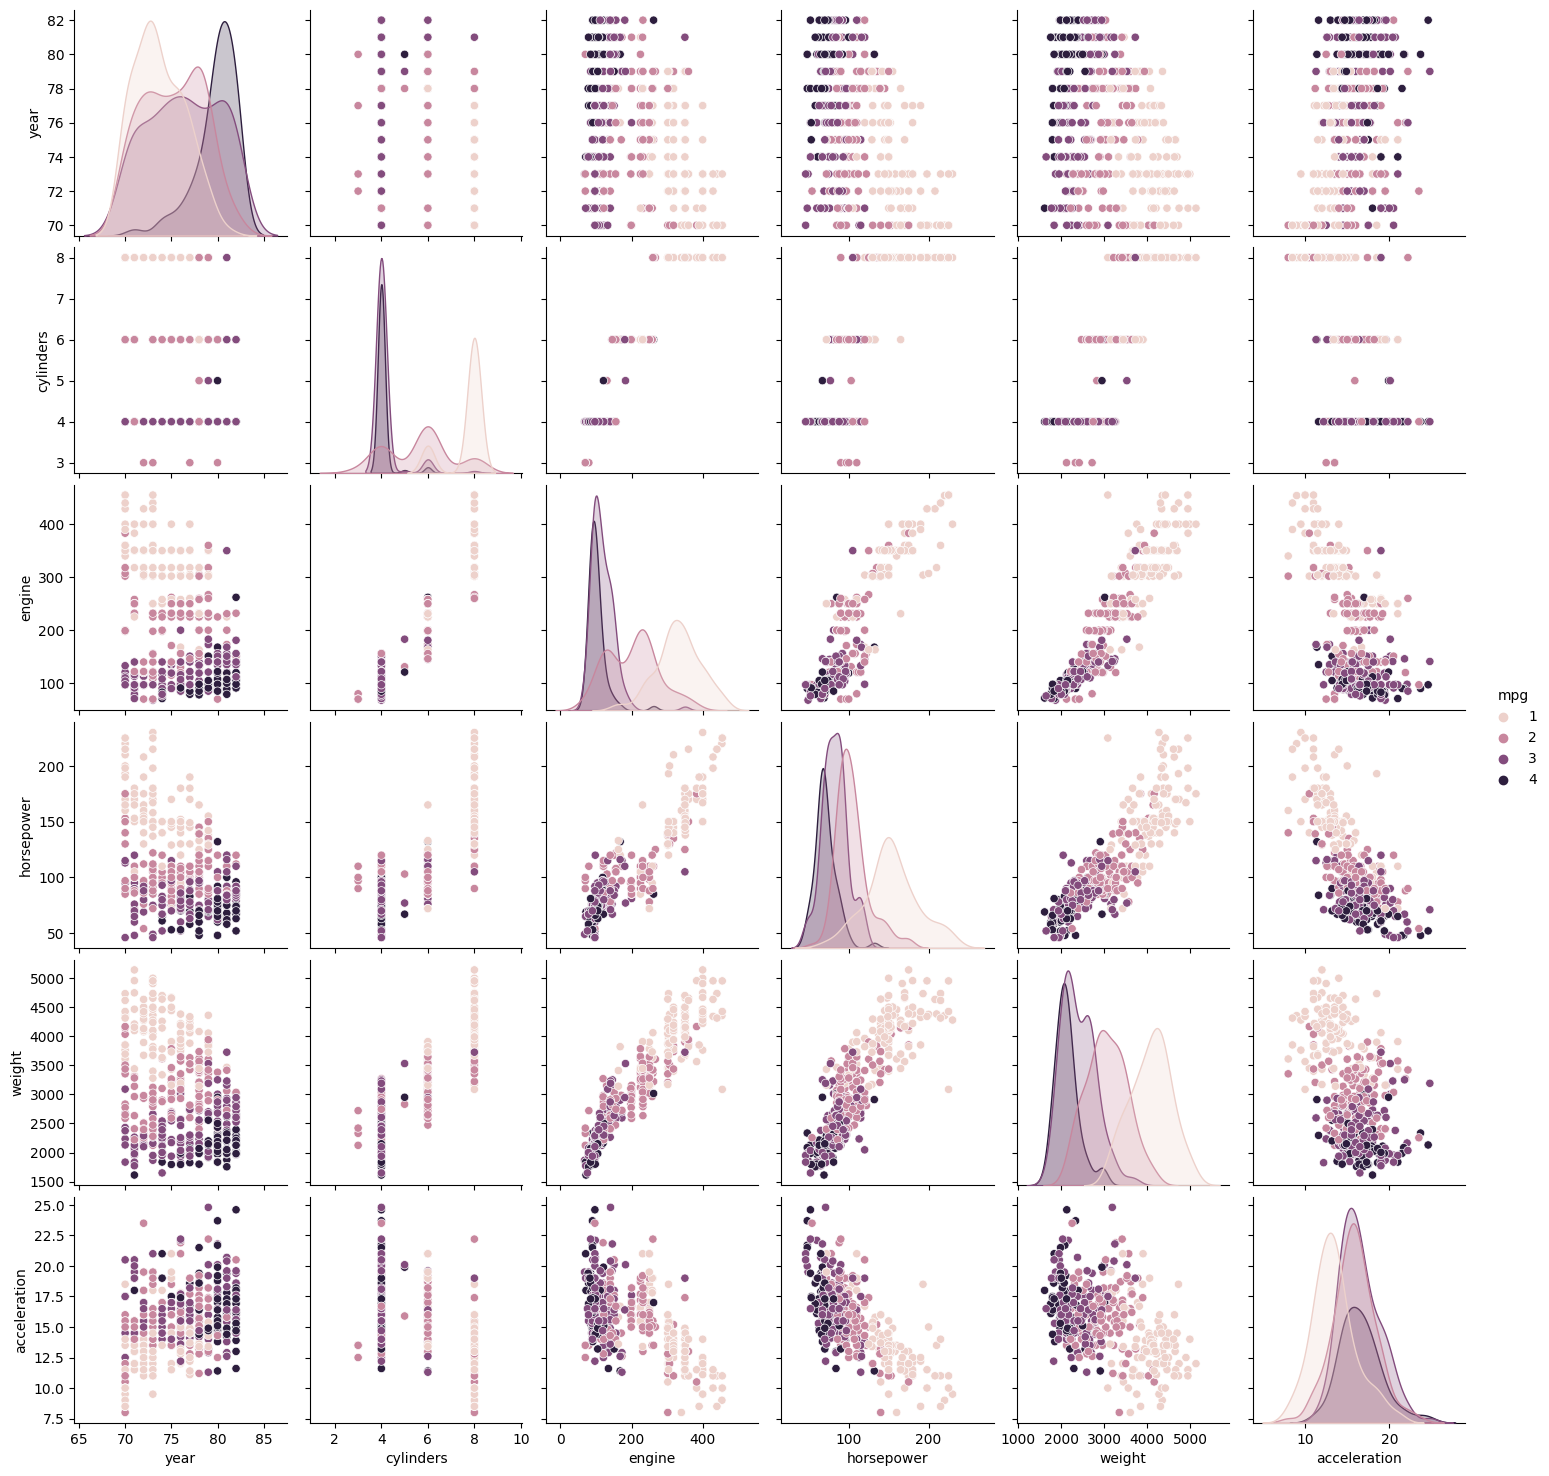

In [18]:
plt.figure()
sns.pairplot(data, hue='mpg')
plt.show()

This graph gives us information about the distribution of our data. It also allows us to ensure that our classes are well defined. 

Our data seems to have a normal distribution for the most part, which is interesting if we plan to use a model that assumes that the data follow a normal distribution.

In addition, we notice that classes 1 and 2 stand out more easily from the others. Our algorithm should therefore find it easier to distinguish individuals belonging to these classes. This is less the case for classes 3 and 4. We also note the very low number of outliers, which is also good news for the supervised learning part.

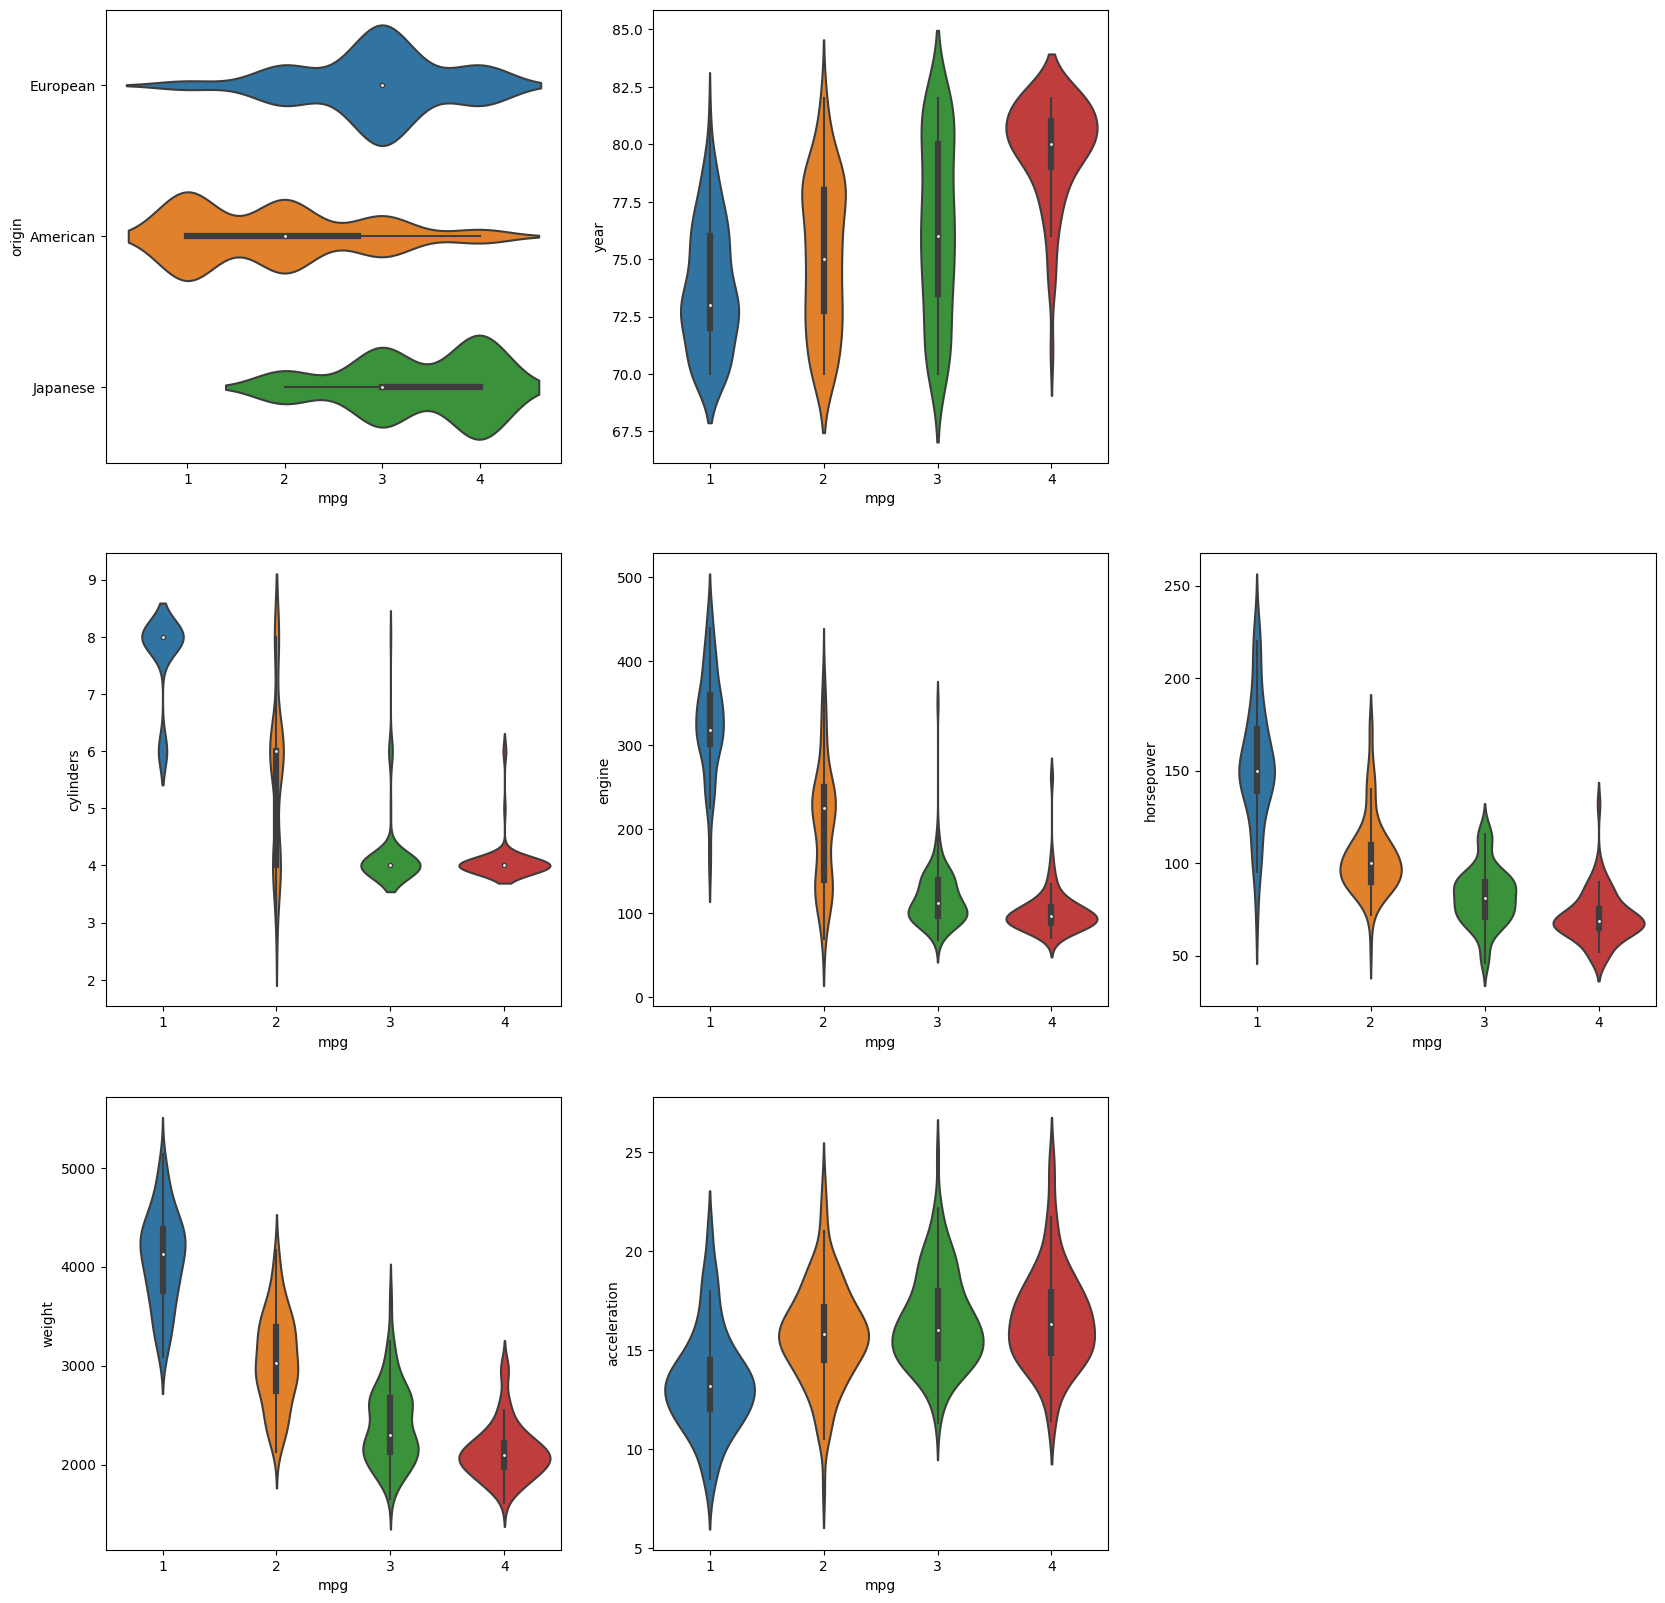

In [19]:
plt.figure(figsize=(20,20))

for index, col in enumerate(data.columns) : 
    if (col == "mpg") or (col == "name"):
        continue
    plt.subplot(3, 3, index)
    sns.violinplot(x='mpg', y=col, data=data) 

We can also make violin plots of the data to compare class distributions. Violin plots contain the same information as boxplots but also scale according to the density of the data.

Here we can see that the origin of the vehicle seems to give a great deal of information about class suitability. For example, the majority of vehicles in class 4 seem to be of Japanese origin, and those in class 1 seem to be mainly of American origin.

Another important point is to look at the distribution of our classes, to see if we are in a case of unbalanced classes.

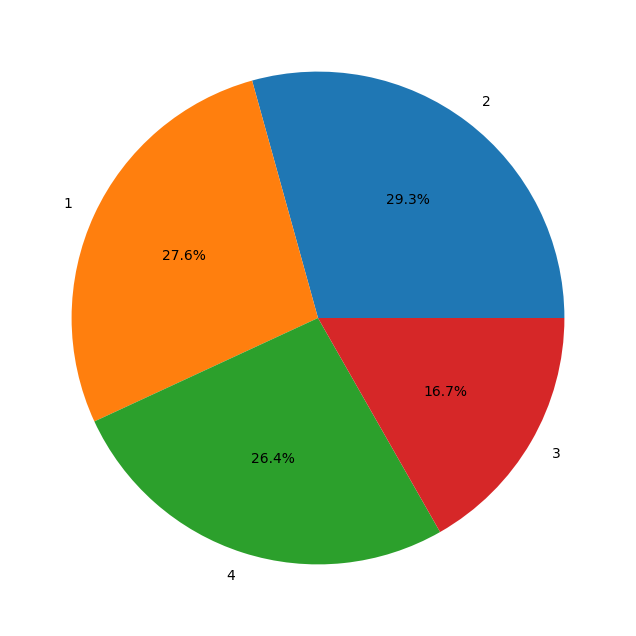

In [20]:
plt.figure(figsize = (12,8))
plt.pie(data['mpg'].value_counts(), labels=data['mpg'].unique(), autopct='%1.1f%%')
plt.show()

Class 3 is in the minority, but we are not in a case of strong imbalance between the classes. A priori, the model will only be slightly affected by this slight imbalance. 

A final observation of interest is the correlation matrix. It gives us information about the correlations between the variables.

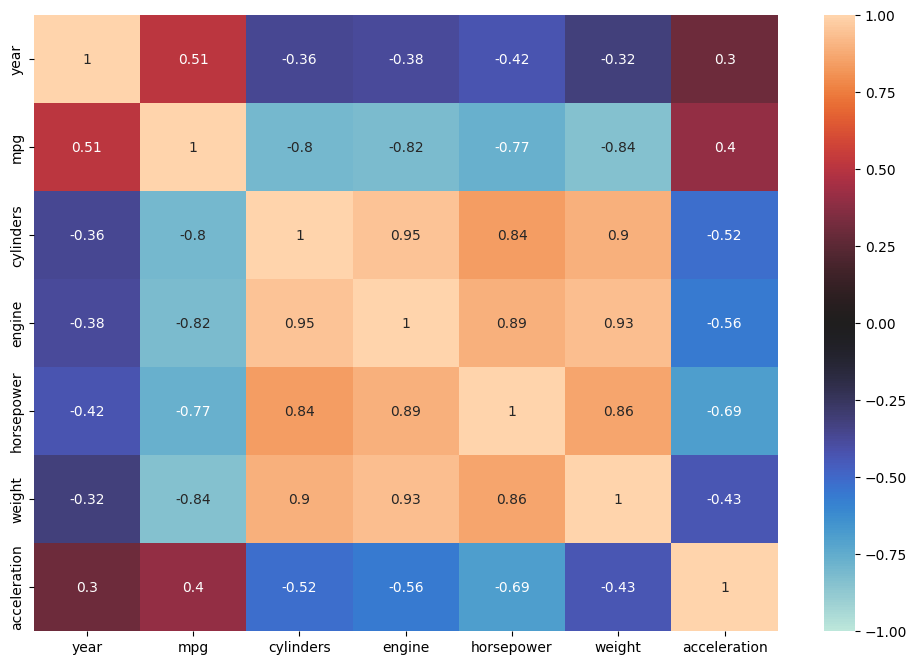

In [23]:
plt.figure(figsize = (12,8))
sns.heatmap(data.select_dtypes(['int', 'float']).corr(), annot=True, vmax=1, vmin=-1, center=0)
plt.show()

We can see that the cylinders, engine, horsepower and weight variables are inversely correlated with the mpg variable (our target variable). Knowing that a negative correlation between two variables indicates that the values of one variable tend to increase when those of the other variable decrease. And that for the Python correlation function, the variable mpg is of type int. We can deduce from this that when the variables cylinders, engine, horsepower and weight increase, the vehicles tend to be of class 1 and 2 and vice versa. 

Now that we've collected enough data from our dataset and cleaned it up, we can move on to the next stage, which is choosing a model.

## Modeling

We have chosen to use classification trees to solve our problem. The advantage of classification trees is that they are scale invariant, meaning that the scale of features does not affect their performance, unlike many machine learning models. In other words, it doesn't matter whether our features range from 0 to 1 or 0 to 1,000, decision tree classifiers will work with them in the same way.

However, we need to encode our object variables, because a decision tree only takes numerical variables into account.

In [31]:
# Drop useless name column
data.drop('name', axis=1, inplace=True)

# Dummy encodage
data = preprocess(data)
data.head()

,year,mpg,cylinders,engine,horsepower,weight,acceleration,origin_American,origin_European,origin_Japanese
0,76,2,4,130.0,102.0,3150,15.7,0,1,0
1,76,1,8,304.0,120.0,3962,13.9,1,0,0
2,71,2,6,258.0,110.0,2962,13.5,1,0,0
3,73,2,6,232.0,100.0,2945,16.0,1,0,0
4,80,4,4,90.0,48.0,2335,23.7,0,1,0


Now that we've encoded our variables, we can define the variables that will be used for learning, and the one that is our target variable (mpg). Furthermore, algorithms generally take arrays of data as input (of the numpy.array type).

In [32]:
inputs = data[
    ['year', 'cylinders','engine', 'horsepower', 'weight',
    'acceleration', 'origin_American', 'origin_European', 'origin_Japanese']
].values

classes = data['mpg'].values

Ensuite nous allons séparer nos données en train et test set. La partie train qui contient la majorité de nos données va servir à entrainer nos données (comme son nom l'indique). La partie test nous sert à valider l'éfficacité de notre modèle.

In [34]:
(
    X_train,
    X_test,
    y_train,
    y_test
) = train_test_split(inputs, classes, train_size=0.75, random_state=42)

Now that we've defined our matrices, we can use a first model, a DecisionTreeClassifier, the simplest model based on the tree function. We are not going to parameterise this model in order to see its basic performance (knowing that by parameterising the decision tree, we will increase its performance).

In [35]:
DecisionTree = DecisionTreeClassifier()
DecisionTree.fit(X_train, y_train)
DecisionTree.score(X_test, y_test)

0.7647058823529411

The result is acceptable, but leaves room for improvement. Moreover, this result may be sensitive to the partition of the data selected for the train set. Depending on the data selected for the train set, the performance of our model may vary. So we're going to do a simple check by repeating the operation 100 times (bearing in mind that a simple decision tree on a dataset of this size takes very little time to build, so our code shouldn't run too long for 100 iterations).

<Figure size 1200x500 with 0 Axes>

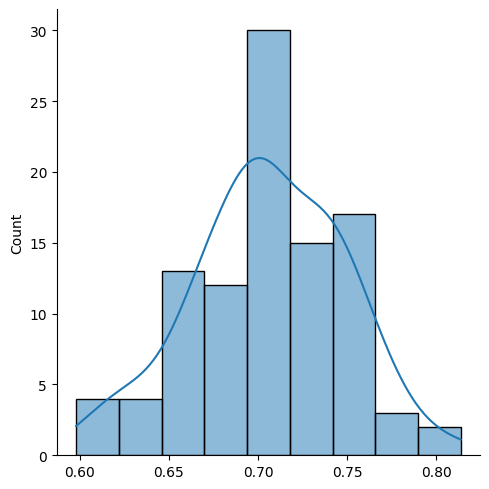

In [38]:
model_accuracies = []

for repetition in range(100):
    (
        training_inputs,
        testing_inputs,
        training_classes,
        testing_classes
    ) = train_test_split(inputs, classes, train_size=0.75)
    
    DecisionTree = DecisionTreeClassifier()
    DecisionTree.fit(training_inputs, training_classes)
    classifier_accuracy = DecisionTree.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)

plt.figure(figsize = (12,5))   
sns.displot(model_accuracies, kde=True)
plt.show()

Our fears have been confirmed: the performance of our model varies greatly depending on the train set. One method of solving this problem is cross-validation. 

Cross-validation divides the original data set into k subsets, uses one of the subsets as a test set, and the remaining subsets are used as training sets. This process is then repeated k times so that each subset is used as a test set exactly once.

Cross-validation with k = 10 is the most common choice, so we'll use this value.

<Figure size 1200x500 with 0 Axes>

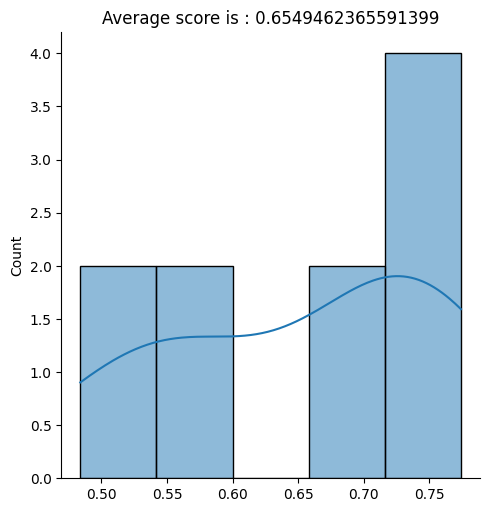

In [40]:
cv_scores = cross_val_score(DecisionTree, training_inputs, training_classes, cv=10)

plt.figure(figsize = (12,5))
sns.displot(cv_scores, kde=True)
plt.title(f"Average score is : {np.mean(cv_scores)}")
plt.show()

We now have a much more accurate assessment of the accuracy of our model.

We will now improve our model by modifying its hyper-parameters. 

However, we are also going to test another algorithm that could give us better results than a simple decision tree. The RandomForest algorithm. A random forest is a meta-estimator that fits a number of decision tree classifiers on various subsamples of the dataset and uses averaging to improve predictive accuracy and control over-fitting.

## Optimization and validation

We use grid search to test a set of values for each hyper-parameter and then look for the best combination to maximise the model's performance.

In [41]:
params = {
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random'],
    'max_features' : [4, 6, 8, 10],
    'max_depth' : [8, 10, 12, None]
}

grid_search = GridSearchCV(DecisionTree, param_grid=params, cv=10)
grid_search.fit(training_inputs, training_classes)

print(f"Best score : {grid_search.best_score_}")
print(f"Best parameters : {grid_search.best_params_}")
print(f"Best estimator : {grid_search.best_estimator_}")

DecisionTree = grid_search.best_estimator_

Best score : 0.7372043010752688
Best parameters : {'criterion': 'gini', 'max_depth': 8, 'max_features': 6, 'splitter': 'random'}
Best estimator : DecisionTreeClassifier(max_depth=8, max_features=6, splitter='random')


Finally, we define our decision tree with the best hyper-parameters. 

We perform the same operation for the RandomForest.

In [43]:
RandonForest = RandomForestClassifier()

params = {
    'n_estimators' : [150, 200, 250],
    'criterion' : ['gini', 'entropy'],
    'max_features' : [2, 4, 6],
    'max_depth' : [10, 12, 14, None]
}

grid_search = GridSearchCV(RandonForest, param_grid=params, cv=10)
grid_search.fit(training_inputs, training_classes)

print(f'Best score : {grid_search.best_score_}')
print(f'Best parameters : {grid_search.best_params_}')
print(f'Best estimator : {grid_search.best_estimator_}')

RandonForest = grid_search.best_estimator_

Best score : 0.7632258064516129
Best parameters : {'criterion': 'entropy', 'max_depth': 10, 'max_features': 2, 'n_estimators': 200}
Best estimator : RandomForestClassifier(criterion='entropy', max_depth=10, max_features=2,
                       n_estimators=200)


We get better results with RandomForest! This can be explained by the construction of the RandomForest agorithm: even a training set made up of several trees with poor performance will perform well when the trees are assembled together. The set therefore represents a strong model.

We're now going to compare the two algorithms to make sure that RandomForest is the one that will give us the best performance.

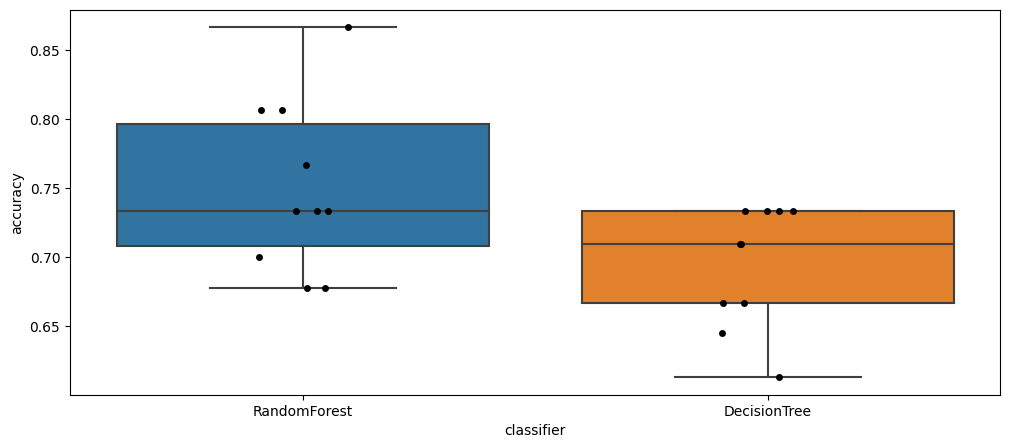

In [44]:
rf_data = pd.DataFrame(
    {
        'accuracy' : cross_val_score(RandonForest, training_inputs, training_classes, cv=10),
        'classifier' : ['RandomForest'] * 10
    }
)
dt_data = pd.DataFrame(
    {
        'accuracy' : cross_val_score(DecisionTree, training_inputs, training_classes, cv=10),
        'classifier' : ['DecisionTree'] * 10
    }
)

tot_data = pd.concat([rf_data, dt_data], axis=0)

plt.figure(figsize = (12,5))
sns.boxplot(x='classifier', y='accuracy', data=tot_data)
sns.stripplot(x='classifier', y='accuracy', data=tot_data, jitter=True, color='black')
plt.show()

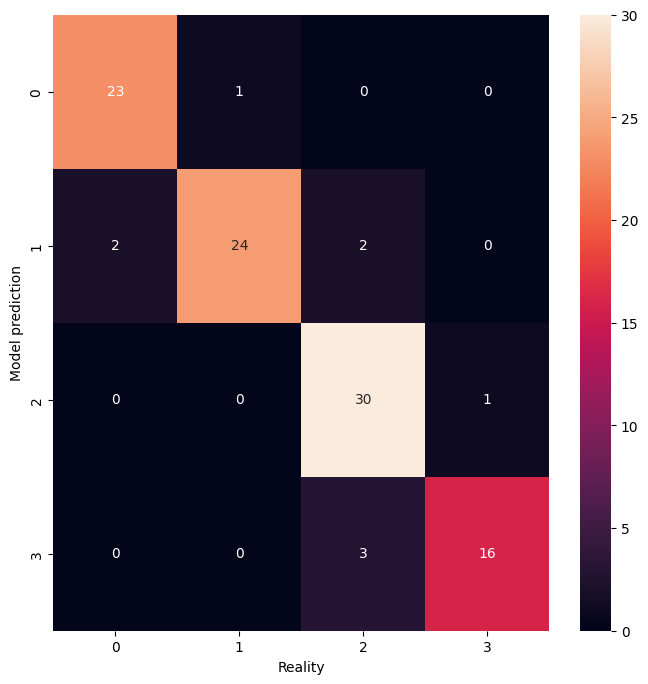

In [45]:
y_pred = RandonForest.predict(X_test)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
plt.xlabel("Reality")
plt.ylabel("Model prediction")
plt.show()

## Conclusion

This graph clearly shows that the RandomForest algorithm performs better. Performance is probably limited by our dataset. In order to achieve better performance, a larger dataset may be a solution. 

So, to conclude this project, we have seen the process of processing the data in order to prepare it for graphical analysis. Finally, we have seen the implementation and improvement of machine learning models such as decision trees and random forests. 

With a RandomForest we were able to obtain an average scoring of 76%. We deliberately did not turn to algorithms using boosting methods such as BaggingClassifier, AdaboostClassifier or XGBoostClassifier, because the data we had available did not require us to embark on more complex algorithms such as these. They are also easier to parameterise. 

The results are good with RandomForest, and fairly simple data like ours doesn't require a more complex algorithm (the results would be the same with XGBoost, Adaboost, etc.).